In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats

# CMA aging Atlas: Heart
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Heart data, Smart-seq2 assay in .h5ad format was used for further analysis.

In [2]:
# Directories
input_dir = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/'
modelmx = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/activation_model.xlsx' 
output_dir = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Revision_1/Output/Heart/'

## Importing and preprocessing data

In [3]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad(input_dir + 'TM_heart.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [4]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel(modelmx)

# Removing EEF1A1 and RAC1 genes because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|██████████| 16/16 [00:00<00:00, 10942.26it/s]
9669it [00:10, 909.39it/s]


In [5]:
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,cell_type,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,u9>4eO>X6P,0.025783
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,l#3^K>nNvx,0.191401
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,5%z9#;_7A^,0.093941
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,fibroblast of cardiac tissue,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,CJH-5s93oA,-0.107985
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,B cell,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,{G7RMS})0?,-0.015457


## Dataset statistics

In [6]:
# Output dir for cell counts
output_dir = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Revision_1/Output/'

In [7]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'stats_age'] = 'Young'

    else:                        
        barcode.loc[j, 'stats_age'] = 'Old'

In [9]:
# Change in cell names
barcode.cell_type.replace('regular atrial cardiac myocyte', 'myocyte', inplace=True)
barcode.cell_type.replace('regular ventricular cardiac myocyte', 'myocyte', inplace=True)
barcode.cell_type.unique()

['B cell', 'fibroblast of cardiac tissue', 'endothelial cell of coronary artery', 'monocyte', 'macrophage', 'endocardial cell', 'cardiac valve cell', 'myocyte', 'T cell', 'smooth muscle cell']
Categories (10, object): ['T cell', 'smooth muscle cell', 'macrophage', 'B cell', ..., 'endocardial cell', 'fibroblast of cardiac tissue', 'endothelial cell of coronary artery', 'cardiac valve cell']

In [10]:
cells = ['myocyte']

In [11]:
# Exploring cell counts
data = barcode[barcode['cell_type'].isin(cells)].value_counts(['cell_type', 'sex', 'stats_age', 'donor_id']).reset_index()
data.sort_values(by=['cell_type', 'sex', 'stats_age', 'donor_id'], 
                 ascending=[True, True, False, True], inplace=True)
data.reset_index(drop=True, inplace=True)
data.rename(columns={0: 'Counts'}, inplace=True)
data

,cell_type,sex,stats_age,donor_id,Counts
0,myocyte,female,Young,3_38_F,5
1,myocyte,female,Young,3_38_F/3_39_F,73
2,myocyte,female,Young,3_39_F,22
3,myocyte,female,Young,3_56_F,13
4,myocyte,female,Old,18_46_F,23
5,myocyte,female,Old,18_47_F,42
6,myocyte,male,Young,3_8_M,4
7,myocyte,male,Young,3_9_M,4
8,myocyte,male,Young,3_10_M,13
9,myocyte,male,Young,3_10_M/3_11_M,54


In [12]:
# Function to extract cell counts
def datastats(cellpop):
    data2 = data[data.cell_type==cellpop]
    data2['Sex_age'] = data2['sex'].astype('str') + '_' + data2['stats_age'].astype('str')
    data2 = data2[['Sex_age', 'donor_id', 'Counts']]
    data2.sort_values(by=['Sex_age', 'donor_id', 'Counts'], ascending=[False, True, True],
                      inplace=True)
    custom_order = ['female_Young', 'female_Old', 'male_Young', 'male_Old']
    data2['Sex_age'] = pd.Categorical(data2['Sex_age'], categories=custom_order, ordered=True)

    data2 = data2.pivot_table(index='donor_id', columns='Sex_age', values='Counts', 
                              aggfunc='first')

    data2.reset_index(inplace=True)
    with pd.ExcelWriter(output_dir + "Cell_counts.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        data2.to_excel(writer, sheet_name= cellpop, index=True)

In [13]:
for i in cells:
    datastats(cellpop=i)

## CMA net score/cell type (fold over whole tissue)

In [6]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '3m':        
        barcode.loc[j, 'new_age'] = '3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-24m'

    elif barcode.loc[j, 'age'] == '24m': 
        barcode.loc[j, 'new_age'] = '18-24m'
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,assay,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,u9>4eO>X6P,0.025783,18-24m
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,l#3^K>nNvx,0.191401,18-24m
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,5%z9#;_7A^,0.093941,18-24m
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,CJH-5s93oA,-0.107985,18-24m
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,Smart-seq2,normal,Mus musculus,female,heart,na,18 month-old stage,{G7RMS})0?,-0.015457,18-24m


In [7]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,disease,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,normal,Mus musculus,female,heart,na,18 month-old stage,u9>4eO>X6P,0.025783,18-24m,-0.001115
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,normal,Mus musculus,female,heart,na,18 month-old stage,l#3^K>nNvx,0.191401,18-24m,0.164504
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,normal,Mus musculus,female,heart,na,18 month-old stage,5%z9#;_7A^,0.093941,18-24m,0.067043
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,normal,Mus musculus,female,heart,na,18 month-old stage,CJH-5s93oA,-0.107985,18-24m,-0.134883
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,normal,Mus musculus,female,heart,na,18 month-old stage,{G7RMS})0?,-0.015457,18-24m,-0.042355


In [9]:
print(list(barcode.cell_type.unique()))

['B cell', 'fibroblast of cardiac tissue', 'endothelial cell of coronary artery', 'monocyte', 'macrophage', 'endocardial cell', 'cardiac valve cell', 'regular atrial cardiac myocyte', 'T cell', 'smooth muscle cell', 'regular ventricular cardiac myocyte']


In [8]:
# Generating new cell types combining some of them
for j in tqdm(barcode.index):    
    if barcode.loc[j, 'cell_type'] == 'fibroblast of cardiac tissue':        
        barcode.loc[j, 'new_cell'] = 'fibroblast'

    elif barcode.loc[j, 'cell_type'] == 'endothelial cell of coronary artery':                
        barcode.loc[j, 'new_cell'] = 'endothelial cell'
    
    elif barcode.loc[j, 'cell_type'] == 'regular atrial cardiac myocyte':                
        barcode.loc[j, 'new_cell'] = 'myocyte'
    
    elif barcode.loc[j, 'cell_type'] == 'regular ventricular cardiac myocyte':                
        barcode.loc[j, 'new_cell'] = 'myocyte'
        
    else:
        barcode.loc[j, 'new_cell'] = barcode.loc[j, 'cell_type']
        
barcode.head()

  0%|          | 0/9669 [00:00<?, ?it/s]

100%|██████████| 9669/9669 [00:00<00:00, 17682.45it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,organism,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,new_cell
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,Mus musculus,female,heart,na,18 month-old stage,u9>4eO>X6P,0.025783,18-24m,-0.001115,B cell
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,Mus musculus,female,heart,na,18 month-old stage,l#3^K>nNvx,0.191401,18-24m,0.164504,B cell
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,Mus musculus,female,heart,na,18 month-old stage,5%z9#;_7A^,0.093941,18-24m,0.067043,B cell
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,Mus musculus,female,heart,na,18 month-old stage,CJH-5s93oA,-0.107985,18-24m,-0.134883,fibroblast
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,Mus musculus,female,heart,na,18 month-old stage,{G7RMS})0?,-0.015457,18-24m,-0.042355,B cell


In [9]:
cells = ['myocyte']

## CMA net score/cell type & sex (fold over each cell type young)

In [10]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['new_cell'])):
    
    µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['score'])
    
    for cell_index in barcode[barcode['new_cell'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

100%|██████████| 10/10 [00:00<00:00, 18.83it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,sex,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,new_cell,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,female,heart,na,18 month-old stage,u9>4eO>X6P,0.025783,18-24m,-0.001115,B cell,0.133102
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,female,heart,na,18 month-old stage,l#3^K>nNvx,0.191401,18-24m,0.164504,B cell,0.298720
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,female,heart,na,18 month-old stage,5%z9#;_7A^,0.093941,18-24m,0.067043,B cell,0.201260
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,female,heart,na,18 month-old stage,CJH-5s93oA,-0.107985,18-24m,-0.134883,fibroblast,-0.148490
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,female,heart,na,18 month-old stage,{G7RMS})0?,-0.015457,18-24m,-0.042355,B cell,0.091862


### Graphs

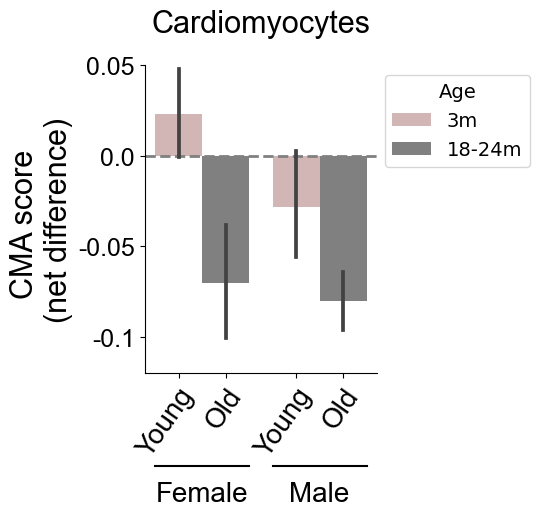

In [13]:
# Figure Cardiomyocytes
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.new_cell=='myocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.12, 0.05)
ax.set_yticks([-0.10, -0.05, 0.00, 0.05])
ax.set_yticklabels([-0.10, -0.05, 0.00, 0.05], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Cardiomyocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)


plt.savefig(output_dir + '/Heart/Myo_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [17]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['new_cell']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    df_raw.to_excel(output_dir + "/Heart/Raw_data.xlsx", sheet_name="CellNsbysex", index=False)
        
    return(df_raw)

In [18]:
raw(tipos = cells, edad=['3m', '18-24m'], sex=['female', 'male'])

,Cell_type,Age,Sex,n,Mean,SEM
0,myocyte,3m,female,113,0.023128,0.024567
1,myocyte,3m,male,92,-0.028407,0.030156
2,myocyte,18-24m,female,65,-0.070391,0.032801
3,myocyte,18-24m,male,280,-0.080280,0.016114


## CMA network heatmaps by cell type & sex

In [19]:
# Load matrix reordered
model_matrix = pd.read_excel(modelmx, 'reordered')

# Removing EEF1A1 and RAC1 because they don't appear in the adata
model_matrix = model_matrix.drop([6, 8], axis=0).reset_index()

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'PHLPP1', 'NFATC1', 'NCOR1', 'NFE2L2', 'RAB11A', 
          'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [20]:
# Function for heatmap
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((16, 4))
    
    # Find cell indices for each condition
    female_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "3m"].index)
    female_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-24m"].index)
    male_3m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "3m"].index)
    male_18_24m = list(barcode[barcode['new_cell'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-24m"].index)
    
    # Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    # Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter(output_dir + "/Heart/Raw_data.xlsx", mode="a", if_sheet_exists='replace', 
                        engine="openpyxl") as writer:
        df_m.to_excel(writer, sheet_name=cellpop+'_heat', index=True)
        
    # Plot heatmap        
    
    fig, ax = plt.subplots(figsize=(6,6))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

    plt.yticks(np.arange(16), model_matrix['Gene name'], fontsize=16, **hfont)

    plt.ylim(15.5, -0.5)

    plt.xticks(np.arange(4), ['3m', '18-24m', '3m', '18-24m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
    plt.title(cellpop.title(), fontdict={'family':'Arial', 'size': 22}, y=1.05)

    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans = ax.get_yaxis_transform()
    trans2 = ax.get_xaxis_transform()
    ax.annotate('Effectors', xy=(-1.5, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                color='k', size=16, **hfont)
    ax.plot([-1.25,-1.25],[-0.25, 4.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Pos. regulators', xy=(-1.5, 4.75), xycoords=trans, ha='left', rotation=90, va="top", 
                color='green', size=16, **hfont)
    ax.plot([-1.25,-1.25],[4.75, 10.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Neg. regulators', xy=(-1.5, 10.5), xycoords=trans, ha='left', rotation=90, va="top", 
                color='red', size=16, **hfont)
    ax.plot([-1.25,-1.25],[11, 15.25], color="k", transform=trans, clip_on=False)

    ax.annotate('Female', xy=(0.4, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    ax.annotate('Male', xy=(2.6, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    
    plt.savefig(output_dir + '/Heart/{}_heat.png'.format(cellpop),bbox_inches='tight', dpi=300)
    
    plt.show()

100%|██████████| 16/16 [00:00<00:00, 41.82it/s]


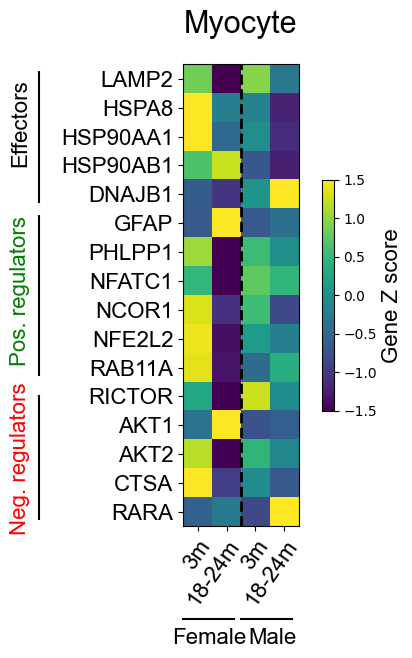

In [21]:
sex_heatmaps(cellpop='myocyte')

# Lysosomal genes

In [14]:
# Directories
modelmx = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/lysosomal_genes.xlsx' 

In [15]:
# Reading table with genes
genes = pd.read_excel(modelmx, 'Review_genes') 

In [15]:
# First trial finding genes in adata raised error, 
# so here we remove not found genes
notfound = ['ENSMUSG00000035953', 'ENSMUSG00000038295', 'ENSMUSG00000006056', 
            'ENSMUSG00000029104', 'ENSMUSG00000050697', 'ENSMUSG00000028518', 
            'ENSMUSG00000032127', 'ENSMUSG00000053647']

idx_val = genes.loc[genes['Ensembl Ms'].isin(notfound)].index.tolist()

# Removing genes not present
model_matrix = genes.drop(idx_val, axis=0).reset_index(drop=True)

# Finding genes of interest in the dataset
network = adata[:, model_matrix['Ensembl Ms']]

In [19]:
# Changes in network

# Adding gene symbols to network.var
network.var['Symbol'] = list(model_matrix['Symbol'])

# Generating new ages
for j in network.obs.index:    
    if network.obs.loc[j, 'age'] == '3m':        
        network.obs.loc[j, 'new_age'] = 'Young'
    
    else:
        network.obs.loc[j, 'new_age'] = 'Old'

# Changing cell types
network.obs.cell_type.replace('regular atrial cardiac myocyte', 'myocyte', inplace=True)
network.obs.cell_type.replace('regular ventricular cardiac myocyte', 'myocyte', inplace=True)

# reset obs index
network.obs.reset_index(inplace=True)

custom_age = ['Young', 'Old']

network.obs['new_age'] = pd.Categorical(network.obs['new_age'], 
                                         categories=custom_age, 
                                         ordered=True)

### Lysosome physiology genes

In [21]:
genes = model_matrix[model_matrix['Gene_set']=='Lysosomes']['Symbol'].to_list()
print(genes[:4])
len(genes)

['ASAH1', 'CTSA', 'CTSB', 'CTSD']


54

In [22]:
def lysosomes(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((54, 4))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
    genidx = list(genedf.var[genedf.var['Symbol'].isin(genes)].index)
    genedf = genedf[:, genidx[0]:genidx[-1]+1]
    
    
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
        matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
        matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
        matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=genes)
    df_m.to_excel(output_dir + "Heart{}_raw.xlsx".format(cellpop[:3]), 
                  sheet_name='Lysosomes', index=True)


    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,14))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r', vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(54), genes, fontsize=16, **hfont)

    plt.ylim(53.5, -0.5)

    plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
               rotation=90, fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    ax.annotate('F', xy=(0.4, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('M', xy=(2.6, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'heart{}lysheat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 54/54 [00:01<00:00, 51.53it/s]


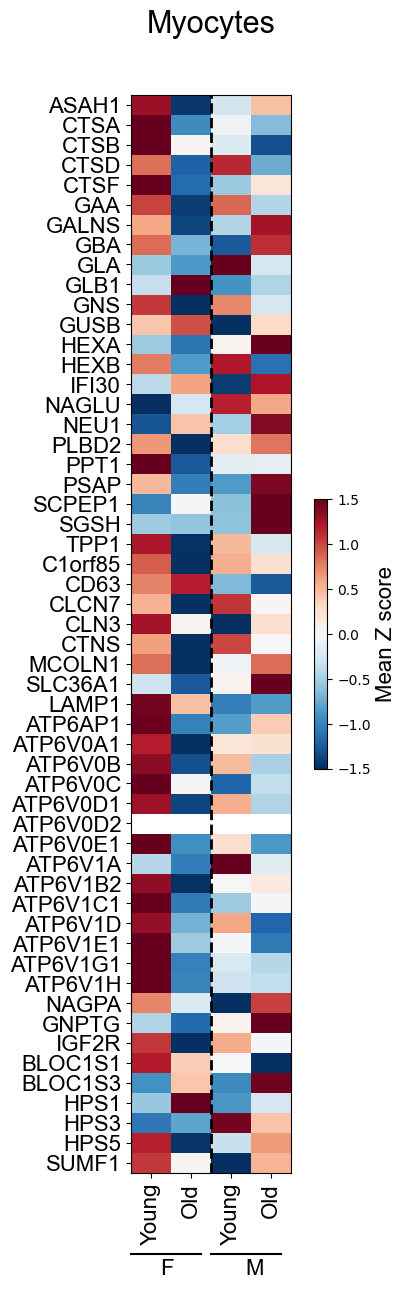

In [23]:
for i in cells:
    lysosomes(cellpop=i)

### Macroautophagy genes

In [24]:
genes = model_matrix[model_matrix['Gene_set']=='Macroautophagy']['Symbol'].to_list()
print(genes[:4])
len(genes)

['AMBRA1', 'ATG3', 'ATG4A', 'ATG4B']


77

In [25]:
# Heatmap for Macro genes
def macro(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((77, 4))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
    genidx = list(genedf.var[genedf.var['Symbol'].isin(genes)].index)
    genedf = genedf[:, genidx[0]:genidx[-1]+1]
    
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
        matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
        matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
        matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=genes)
    with pd.ExcelWriter(output_dir + "Heart{}_raw.xlsx".format(cellpop[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name='Macroautophagy', index=True)

    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(6,18))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r',  vmin=-1.5, vmax=1.5)
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(77), genes, fontsize=16, **hfont)

    plt.ylim(76.5, -0.5)

    plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
               rotation=90, fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    ax.annotate('F', xy=(0.4, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('M', xy=(2.6, -.08), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.075,-.075], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'heart{}MAheat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 77/77 [00:01<00:00, 53.20it/s]


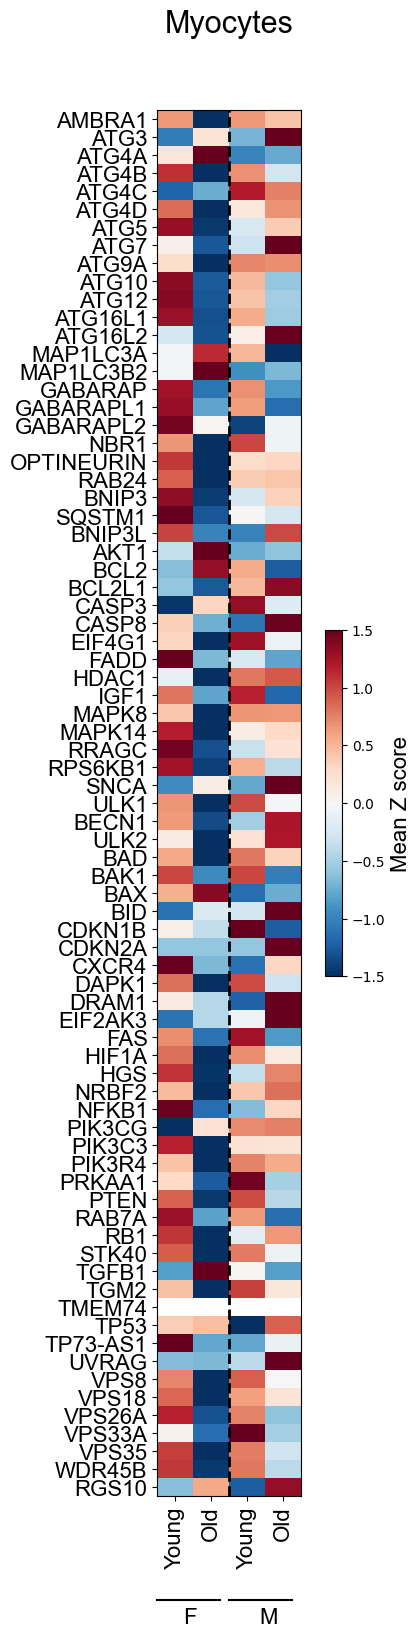

In [26]:
for i in cells:
    macro(cellpop=i)

### Selective MA

In [27]:
genes = model_matrix[model_matrix['Gene_set']=='Selective MA']['Symbol'].to_list()
print(genes[:4])
len(genes)

['Bcl2L13', 'PHB2', 'TAX1BP1', 'PINK']


15

In [28]:
def selective(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((15, 4))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
    genidx = list(genedf.var[genedf.var['Symbol'].isin(genes)].index)
    genedf = genedf[:, genidx[0]:genidx[-1]+1]
    
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
        matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
        matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
        matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=genes)
    with pd.ExcelWriter(output_dir + "Heart{}_raw.xlsx".format(cellpop[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name='Selective MA', index=True)

    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(3,9))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r')
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(15), genes, fontsize=16, **hfont)

    plt.ylim(14.5, -0.5)

    plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
               rotation=90, fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    ax.annotate('F', xy=(0.4, -.27), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.5,1.25],[-.255,-.255], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('M', xy=(2.6, -.27), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.5, 3.25],[-.255,-.255], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'heart{}selMAheat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 15/15 [00:00<00:00, 56.62it/s]


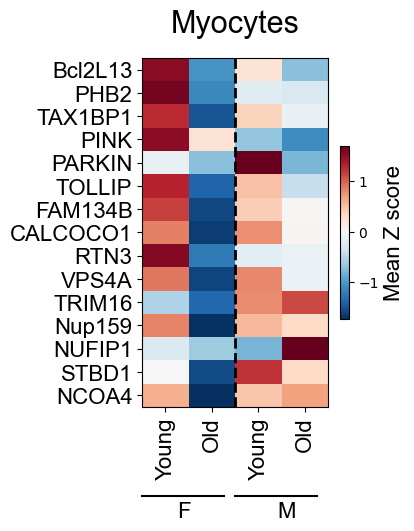

In [29]:
for i in cells:
    selective(cellpop=i)

### Extra lysosomal genes

In [35]:
# Directories
modelmx = r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/lysosomal_genes.xlsx' 

In [36]:
# Reading table with genes
modelmx = pd.read_excel(modelmx, 'LysExtra') 
genes = list(modelmx['Symbol'])

In [38]:
# Finding genes of interest in the dataset
network = adata[:, modelmx['Ensembl Ms']]
network.var_names

Index(['ENSMUSG00000023990', 'ENSMUSG00000000134', 'ENSMUSG00000029553'], dtype='object')

In [39]:
# Changes in network

# Adding gene symbols to network.var
network.var['Symbol'] = list(modelmx['Symbol'])

# Generating new ages
for j in network.obs.index:    
    if network.obs.loc[j, 'age'] == '3m':        
        network.obs.loc[j, 'new_age'] = 'Young'
    
    else:
        network.obs.loc[j, 'new_age'] = 'Old'

# Changing cell types
network.obs.cell_type.replace('regular atrial cardiac myocyte', 'myocyte', inplace=True)
network.obs.cell_type.replace('regular ventricular cardiac myocyte', 'myocyte', inplace=True)

# reset obs index
network.obs.reset_index(inplace=True)

custom_age = ['Young', 'Old']

network.obs['new_age'] = pd.Categorical(network.obs['new_age'], 
                                         categories=custom_age, 
                                         ordered=True)

In [65]:
def selective(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((3, 4))

    # Find genes in network.var
    genedf = network.copy()
    genedf.var.reset_index(inplace=True)
        
    #Find cell indices for each condition
    female_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Young"].index.astype(int))
    female_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "female"][genedf.obs['new_age'] == "Old"].index.astype(int))
    male_3m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Young"].index.astype(int))
    male_18_24m = list(genedf.obs[genedf.obs['cell_type'] == cellpop][genedf.obs['sex'] == "male"][genedf.obs['new_age'] == "Old"].index.astype(int))

    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(genedf[female_3m, rank].X.todense())
        matrix[rank, 1] = np.mean(genedf[female_18_24m, rank].X.todense())
        matrix[rank, 2] = np.mean(genedf[male_3m, rank].X.todense())
        matrix[rank, 3] = np.mean(genedf[male_18_24m, rank].X.todense())  
    
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd 

    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=genes)
    with pd.ExcelWriter(output_dir + "Heart{}_raw.xlsx".format(cellpop[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name='LysExtra', index=True)

    #Plot heatmap including all conditions
    fig, ax = plt.subplots(figsize=(3,5))
    hfont = {'fontname':'Arial'}

    plt.imshow(matrix_zs, aspect=0.5, cmap='RdBu_r')
    plt.colorbar(shrink=.25).set_label(label="Mean Z score", size=16, **hfont)

    plt.yticks(np.arange(3), genes, fontsize=16, **hfont)

    plt.ylim(2.5, -0.5)

    plt.xticks(np.arange(4), ['Young', 'Old', 'Young', 'Old'], 
               rotation=90, fontsize=16, **hfont)
    plt.title(cellpop.title()+'s', fontdict={'family':'Arial', 'size': 22}, y=1.05)
    
    plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)

    # Annotations
    trans2 = ax.get_xaxis_transform()
    
    ax.annotate('F', xy=(0.4, -1.3), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([-.3,1.25],[-1.15,-1.15], color="k", transform=trans2, clip_on=False)
    
    ax.annotate('M', xy=(2.6, -1.3), xycoords=trans2, ha="center", va="top", size=16, **hfont)
    ax.plot([1.7, 3.25],[-1.15,-1.15], color="k", transform=trans2, clip_on=False)
    
    plt.savefig(output_dir + 'heart{}lysextraheat.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)
    plt.show()

100%|██████████| 3/3 [00:00<00:00, 56.37it/s]


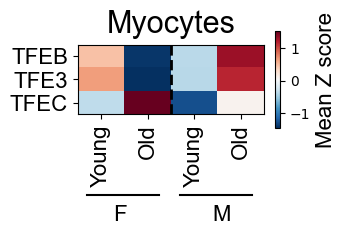

In [66]:
for i in cells:
    selective(cellpop=i)

## Macro score

In [11]:
# Load matrix file with weight and direction 
mamx = pd.read_excel(modelmx, 'Macroautophagy')

# Removing genes not present in the adata
not_found = ['ENSMUSG00000038295', 'ENSMUSG00000006056', 'ENSMUSG00000029104', 
             'ENSMUSG00000050697', 'ENSMUSG00000028518', 'ENSMUSG00000032127']
mamx = mamx.drop(mamx[mamx["Ensembl Ms"].isin(not_found)].index, axis=0).reset_index(drop=True)

# Finding MA network genes in the dataset
ma_network = adata[:, mamx["Ensembl Ms"]]

In [12]:
# Calculating the Zs scores
ma_data_zs = ma_network.copy().X.todense().T

for i in tqdm(np.arange(ma_data_zs.shape[0])):
    
    µ = np.mean(ma_data_zs[i, :])
    sd = np.std(ma_data_zs[i, :])
    
    ma_data_zs[i, :] = (ma_data_zs[i, :] - µ)/sd

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in tqdm(enumerate(barcode.index)):
        
    cell_matrix = mamx.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = ma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['direction'] * cell_matrix['weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['weight'])

    barcode.loc[j, 'ma_score'] = score   

barcode.head()
    

100%|██████████| 78/78 [00:00<00:00, 8910.44it/s]
9669it [00:29, 326.53it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,tissue,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,new_cell,celltype_ns,ma_score
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,heart,na,18 month-old stage,u9>4eO>X6P,0.025783,18-24m,-0.001115,B cell,0.133102,0.048094
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,heart,na,18 month-old stage,l#3^K>nNvx,0.191401,18-24m,0.164504,B cell,0.298720,-0.234013
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,heart,na,18 month-old stage,5%z9#;_7A^,0.093941,18-24m,0.067043,B cell,0.201260,-0.066752
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,heart,na,18 month-old stage,CJH-5s93oA,-0.107985,18-24m,-0.134883,fibroblast,-0.148490,0.212397
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,heart,na,18 month-old stage,{G7RMS})0?,-0.015457,18-24m,-0.042355,B cell,0.091862,-0.144604


In [13]:
# Calculation of ma net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['new_cell'])):
    
    µ = np.mean(barcode[barcode['new_cell'] == maj_cell][barcode['new_age'] == '3m']['ma_score'])
    
    for cell_index in barcode[barcode['new_cell'] == maj_cell].index:
    
        barcode.loc[cell_index, 'macell_ns'] = barcode.loc[cell_index, 'ma_score'] - µ  

barcode.head()

100%|██████████| 10/10 [00:00<00:00, 17.86it/s]


,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,self_reported_ethnicity,development_stage,observation_joinid,score,new_age,net_score,new_cell,celltype_ns,ma_score,macell_ns
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,na,18 month-old stage,u9>4eO>X6P,0.025783,18-24m,-0.001115,B cell,0.133102,0.048094,0.162030
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,na,18 month-old stage,l#3^K>nNvx,0.191401,18-24m,0.164504,B cell,0.298720,-0.234013,-0.120077
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,na,18 month-old stage,5%z9#;_7A^,0.093941,18-24m,0.067043,B cell,0.201260,-0.066752,0.047184
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,na,18 month-old stage,CJH-5s93oA,-0.107985,18-24m,-0.134883,fibroblast,-0.148490,0.212397,0.144107
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,na,18 month-old stage,{G7RMS})0?,-0.015457,18-24m,-0.042355,B cell,0.091862,-0.144604,-0.030668


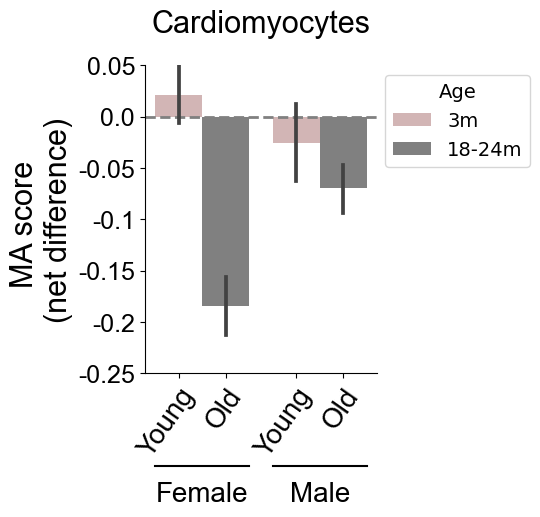

In [42]:
# Figure Cardiomyocytes
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='macell_ns', data=barcode[barcode.new_cell=='myocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['3m', "18-24m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('MA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.25, 0.05)
ax.set_yticks([-0.25, -0.2, -0.15, -0.10, -0.05, 0.00, 0.05])
ax.set_yticklabels([-0.25, -0.2, -0.15, -0.10, -0.05, 0.00, 0.05], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Cardiomyocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)


plt.savefig(output_dir + 'heartmyomans.png',bbox_inches='tight', dpi=600)

plt.show()

In [43]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad=['3m', '18-24m'], sex=['female', 'male']):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for x in edad:
        for y in sex:
            n = len(barcode[barcode['new_cell']== tipos][barcode['new_age']== x][barcode['sex']== y].index)
            m = np.mean(barcode[barcode['new_cell']== tipos][barcode['new_age']== x][barcode['sex']== y]['macell_ns'])
            s = stats.sem(barcode[barcode['new_cell']== tipos][barcode['new_age']== x][barcode['sex']== y]['macell_ns'])

            long.append(n)
            celula.append(tipos)                
            age.append(x)
            sexo.append(y)
            mean.append(m)
            sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter(output_dir + "Heart{}_raw.xlsx".format(tipos[:3]),
                        mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
        df_raw.to_excel(writer, sheet_name='MA score', index=True)

    print(df_raw)

In [44]:
for i in cells:
    raw(tipos = i)

  Cell_type     Age     Sex    n      Mean       SEM
0   myocyte      3m  female  113  0.021155  0.029884
1   myocyte      3m    male   92 -0.025984  0.038073
2   myocyte  18-24m  female   65 -0.184766  0.028128
3   myocyte  18-24m    male  280 -0.070043  0.022593


## Correlation with hormone receptors

In [14]:
# Reading df for hormone receptors
horm = pd.read_excel(r'/home/adrianmartin/Onedrive_IMDEA/Old_labs/Cuervo_lab/Dendra_paper/Raw_data/lysosomal_genes.xlsx', 'Review_genes')
horm_symbol = horm[horm['Gene_set']=='Hormones']['Symbol'].to_list()
horm_ensembl = horm[horm['Gene_set']=='Hormones']['Ensembl Ms'].to_list()

In [15]:
# First trial finding genes in adata raised error, 
# so here we remove not found genes
horm_symbol = [i for i in horm_symbol if i != 'GPER1']
horm_ensembl = [i for i in horm_ensembl if i != 'ENSMUSG00000053647']

# Finding genes of interest in the dataset
hormdf = adata[:, horm_ensembl]
hormdf.layers["scaled"] = sc.pp.scale(hormdf, copy=True).X
hormdf

AnnData object with n_obs × n_vars = 9669 × 6
    obs: 'FACS.selection', 'age', 'cell', 'free_annotation', 'method', 'donor_id', 'subtissue', 'n_genes', 'n_counts', 'louvain', 'leiden', 'assay_ontology_term_id', 'disease_ontology_term_id', 'cell_type_ontology_term_id', 'tissue_ontology_term_id', 'development_stage_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'suspension_type', 'tissue_type', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length'
    uns: 'age_colors', 'citation', 'leiden', 'louvain', 'neighbors', 'pca', 'schema_reference', 'schema_version', 'title', 'log1p'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    layers: 'scaled'

In [16]:
# Dataframe with Hormone Zs values
hormzs = pd.DataFrame(hormdf.layers['scaled'], columns = horm_symbol, index=hormdf.obs.index)
hormzs.head()

,ESR1,ESR2,ANDR,PRGR,XIST,LAMP2
index,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,-0.162358,-0.044904,-0.334161,-0.037968,-0.364928,-1.315256
A11_B001361_B007505_S11.mm10-plus-0-0,-0.162358,-0.044904,-0.334161,-0.037968,-0.364928,0.665932
A12_B001361_B007505_S12.mm10-plus-0-0,-0.162358,-0.044904,-0.334161,-0.037968,-0.364928,-1.315256
A13_B001361_B007505_S13.mm10-plus-0-0,-0.162358,-0.044904,-0.334161,-0.037968,-0.364928,0.903588
A14_B001361_B007505_S14.mm10-plus-0-0,-0.162358,-0.044904,-0.334161,-0.037968,-0.364928,-1.315256


In [18]:
# Merging Barcode and Hormonze Z values dataframe
barcode = pd.merge(barcode, hormzs, how='inner', on='index')
barcode.head()

,FACS.selection,age,cell,free_annotation,method,donor_id,subtissue,n_genes,n_counts,louvain,...,new_cell,celltype_ns,ma_score,macell_ns,ESR1,ESR2,ANDR,PRGR,XIST,LAMP2
index,,,,,,,,,,,,,,,,,,,,,
A10_B001361_B007505_S10.mm10-plus-0-0,Viable,18m,A10_B001361,B cell,facs,18_46_F,RV,1237,3932.890137,10,...,B cell,0.133102,0.048094,0.162030,-0.162358,-0.044904,-0.334161,-0.037968,-0.364928,-1.315256
A11_B001361_B007505_S11.mm10-plus-0-0,Viable,18m,A11_B001361,B cell,facs,18_46_F,RV,1257,3718.219971,10,...,B cell,0.298720,-0.234013,-0.120077,-0.162358,-0.044904,-0.334161,-0.037968,-0.364928,0.665932
A12_B001361_B007505_S12.mm10-plus-0-0,Viable,18m,A12_B001361,B cell,facs,18_46_F,RV,1435,2952.168945,10,...,B cell,0.201260,-0.066752,0.047184,-0.162358,-0.044904,-0.334161,-0.037968,-0.364928,-1.315256
A13_B001361_B007505_S13.mm10-plus-0-0,Viable,18m,A13_B001361,fibroblast of cardiac tissue,facs,18_46_F,RV,3716,4792.129883,3,...,fibroblast,-0.148490,0.212397,0.144107,-0.162358,-0.044904,-0.334161,-0.037968,-0.364928,0.903588
A14_B001361_B007505_S14.mm10-plus-0-0,Viable,18m,A14_B001361,B cell,facs,18_46_F,RV,1331,3465.566162,10,...,B cell,0.091862,-0.144604,-0.030668,-0.162358,-0.044904,-0.334161,-0.037968,-0.364928,-1.315256


In [19]:
def hormones (cellpop):
    for horm in horm_symbol:
        if horm == 'LAMP2':
            break
                
        # Dataframe for non-zero hormone values
        filt = barcode[barcode.new_cell==cellpop]
        filt = filt[filt[horm] > np.min(filt[horm])]

        # Saving raw data
        df = filt[['new_cell', 'sex', 'new_age', 'celltype_ns', horm]]
        with pd.ExcelWriter(output_dir + "Heart{}_raw.xlsx".format(cellpop[:3]),
                            mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
            df.to_excel(writer, sheet_name='{}_corr'.format(horm), index=True)
        
        # Figure
        plot = sns.lmplot(filt, x="celltype_ns", y=horm, hue="sex", 
           hue_order = ("female", "male"), #palette=['#D7B0B0', '#808080'],
           col='new_age', col_wrap=2, col_order=['3m', '18-24m'], legend_out = True)
        titles = ['Young', 'Old']
        for ax, title in zip(plot.axes.flat, titles):
            ax.set_title(title, fontsize=16)
        plot.set_axis_labels("CMA Net Score", "{} Z-score".format(horm), fontsize=14)

        for ax in plot.axes.flat:
            ax.tick_params(axis='x', labelsize=12)
            ax.tick_params(axis='y', labelsize=12)

        new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
        for t, l in zip(plot._legend.texts, new_labels):
            t.set_text(l)
        plt.setp(plot._legend.get_title(), fontsize=14)  
        plt.setp(plot._legend.get_texts(), fontsize=12)
        plot._legend.set_title('Sex')

        plt.savefig(output_dir + 'heart{}{}.png'.format(cellpop[:3], horm),bbox_inches='tight', dpi=600)

        plt.show()

        if horm == 'XIST':
            filt2 = filt[filt['LAMP2'] > np.min(filt['LAMP2'])]
            # Saving raw data
            df = filt2[['new_cell', 'sex', 'new_age', 'celltype_ns', horm, 'LAMP2']]
            with pd.ExcelWriter(output_dir + "Heart{}_raw.xlsx".format(cellpop[:3]),
                                mode="a", if_sheet_exists='replace', engine="openpyxl", ) as writer:
                df.to_excel(writer, sheet_name='{}-L2_corr'.format(horm), index=True)
            
            # XIST-LAMP2 correlation
            plot = sns.lmplot(data=filt2, x="XIST", y="LAMP2", hue = 'sex',
                              hue_order = ("female", "male"),
                              col='new_age', col_wrap=2, col_order=['3m', '18-24m'], 
                              legend_out = True)
            titles = ['Young', 'Old']
            for ax, title in zip(plot.axes.flat, titles):
                ax.set_title(title, fontsize=16)
            plot.set_axis_labels("XIST Z-score", "LAMP2 Z-score", fontsize=14)

            for ax in plot.axes.flat:
                ax.tick_params(axis='x', labelsize=12)
                ax.tick_params(axis='y', labelsize=12)

            new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
            for t, l in zip(plot._legend.texts, new_labels):
                t.set_text(l)
            plt.setp(plot._legend.get_title(), fontsize=14)  
            plt.setp(plot._legend.get_texts(), fontsize=12)
            plot._legend.set_title('Sex')  # Nuevos labels para la leyenda

            plt.savefig(output_dir + 'heart{}xisl2.png'.format(cellpop[:3]),bbox_inches='tight', dpi=600)

            plt.show()
    print('Loop finished')

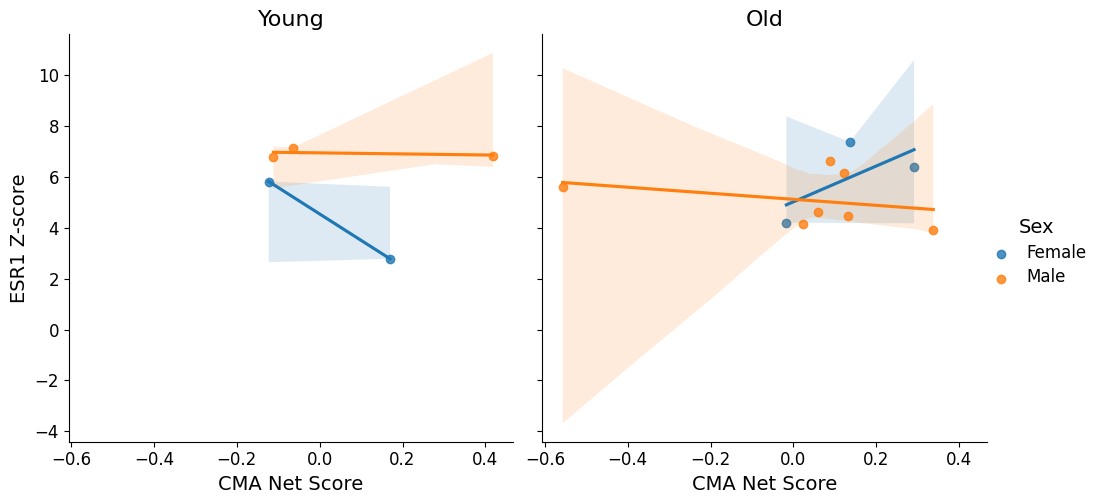

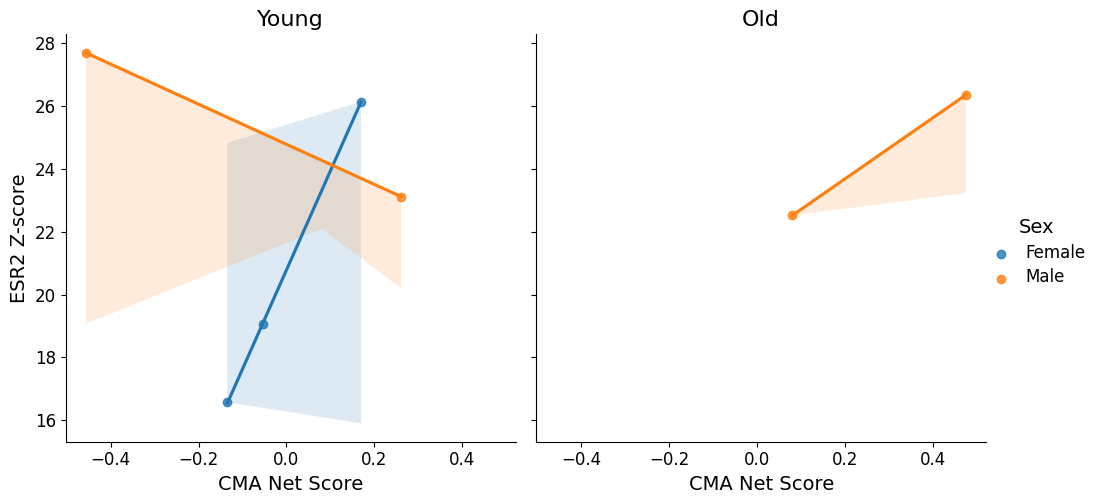

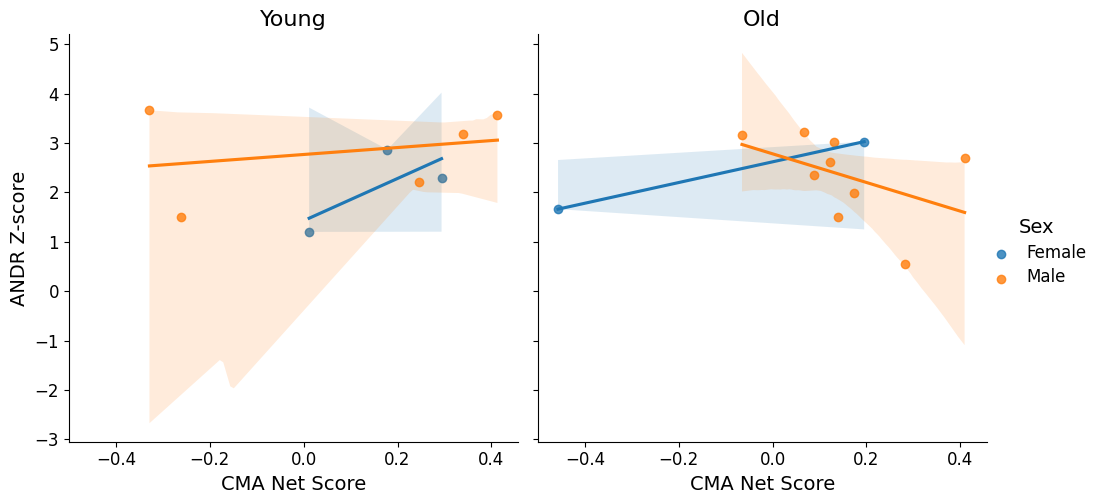

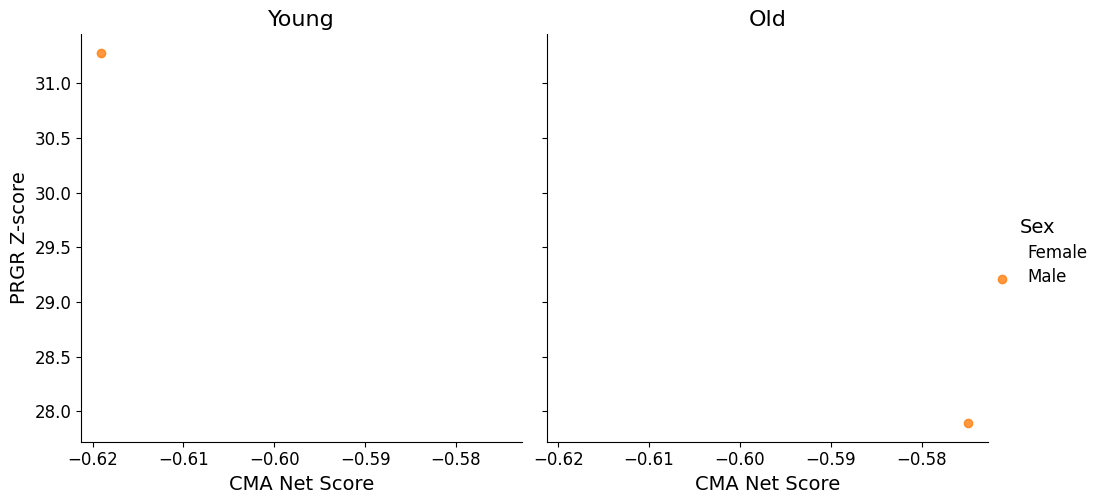

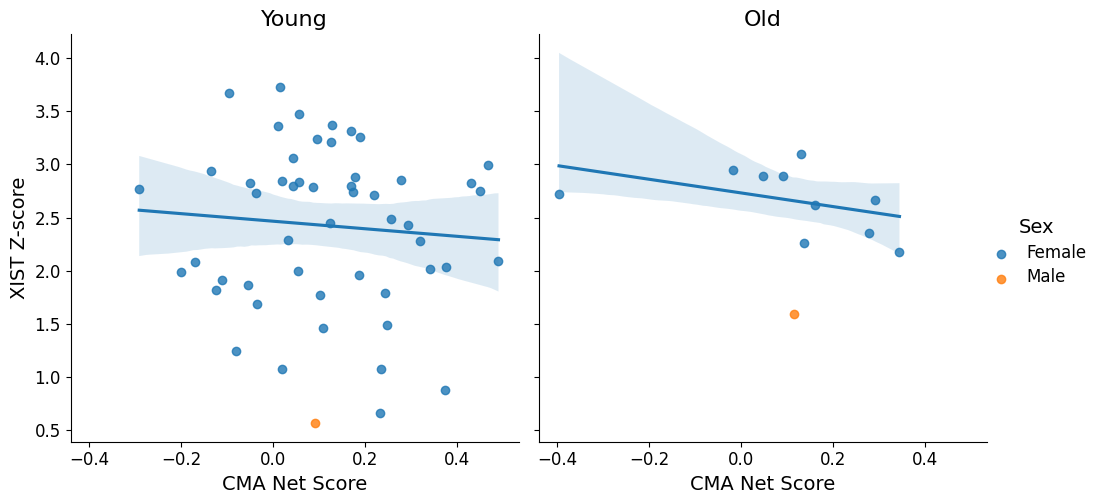

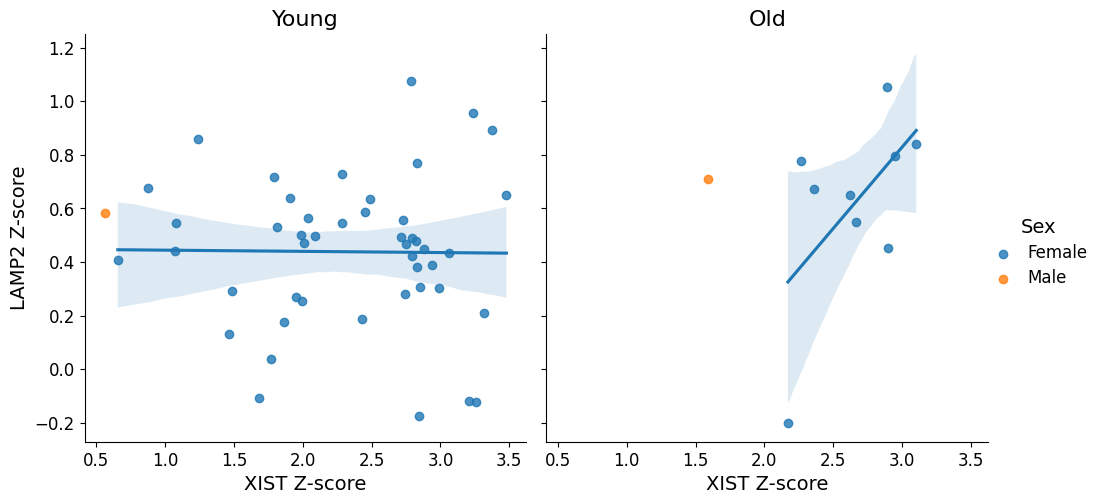

Loop finished


In [20]:
for i in cells:
    hormones(cellpop=i)

## USEFUL BUT NOT USED CODE BELOW THIS LINE
#####################################################################################


In [55]:
filt = barcode[barcode.new_cell=='myocyte']
filt.shape

(550, 44)

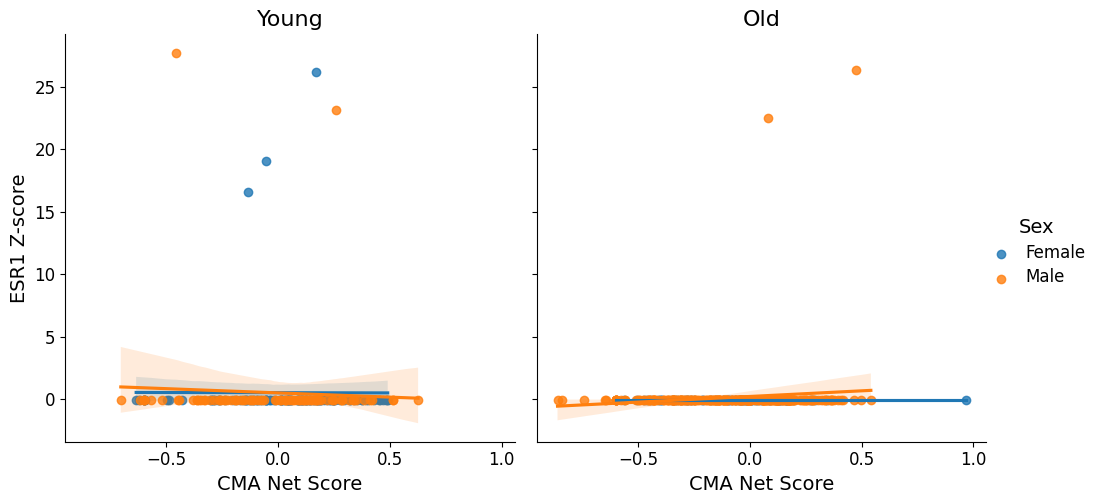

In [58]:
# Correlation removing 0 values
plot = sns.lmplot(filt, x="celltype_ns", y="ESR2", hue="sex", 
           hue_order = ("female", "male"), #palette=['#D7B0B0', '#808080'],
           col='new_age', col_wrap=2, col_order=['3m', '18-24m'], legend_out = True)
titles = ['Young', 'Old']
for ax, title in zip(plot.axes.flat, titles):
    ax.set_title(title, fontsize=16)
plot.set_axis_labels("CMA Net Score", "ESR1 Z-score", fontsize=14)

for ax in plot.axes.flat:
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)

new_labels = ['Female', 'Male']  # Nuevos labels para la leyenda
for t, l in zip(plot._legend.texts, new_labels):
    t.set_text(l)
plt.setp(plot._legend.get_title(), fontsize=14)  
plt.setp(plot._legend.get_texts(), fontsize=12)
plot._legend.set_title('Sex')

plt.show()